# Converting each MOF to a graph
* reads in each MOF from DDEC charge-assigned dataset
* infers bonds using distance-based criterion
* writes to file: 
    * list of crystal names: `list_of_crystals.txt`
    * node features: `graphs/xtalname_node_features.npy`
    * edge list and features: `graphs/xtalname.edge_info`. the edges are 0-based indexed.
    * node labels (charges) `graphs/xtalname_node_labels.npy`

In [3]:
using PorousMaterials # use major_refactor branch.
using DataFrames
using PyPlot
using NPZ
using CSV
using LightGraphs
using LinearAlgebra
using Logging
using Printf
using DelimitedFiles
using ProgressMeter
using PyCall
push!(LOAD_PATH, pwd()) # to see Bonds.jl
using Bonds

# global_logger(Logging.SimpleLogger(stdout, Logging.Info)) # to print @debug put Logging.Debug
global_logger(Logging.SimpleLogger(stdout, Logging.Debug)) # to print @debug put Logging.Debug

┌ Info: Precompiling PorousMaterials [top-level]
└ @ Base loading.jl:1273
┌ Info: Precompiling Bonds [top-level]
└ @ Base loading.jl:1273


Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(0x0000002c) open, 0 bytes waiting))), Info, Dict{Any,Int64}())

### get list of MOFs
MOF `.cif` files with DDEC-assigned charges are found in `xtals/`. These were downloaded from [here](https://github.com/gregchung/gregchung.github.io/blob/master/CoRE-MOFs/core-mof-1.0-ddec.tar). The paper corresponding to these structures is [here](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.5b03836).

In [4]:
@eval PorousMaterials PATH_TO_CRYSTALS = joinpath(pwd(), "xtals")

"/home/sturlusa/my_projects/scratch/mpn_charges/build_graphs/xtals"

In [5]:
xtalnames = map(x -> replace(x, ".cif" => ""), readdir("xtals"))

2932-element Array{String,1}:
 "ABAVIJ_clean"  
 "ABAVOP_clean"  
 "ABEXIQ_clean"  
 "ABEXOW_clean"  
 "ABEXUC_clean"  
 "ABEYAJ_clean"  
 "ABEYIR"        
 "ABIYIV"        
 "ABUWOJ_clean"  
 "ACAKUM"        
 "ACALIB_clean"  
 "ACODED"        
 "ACOLIP_clean"  
 ⋮               
 "ZILBAZ_clean"  
 "ZILBED_clean"  
 "ZIMJOW_clean"  
 "ZISYAD_clean"  
 "ZNGLUD01_clean"
 "ZNGLUD_clean"  
 "ZURQOS_clean"  
 "Zn-DOBDC"      
 "ZnBDC"         
 "ZnBDCdabco"    
 "ZnHBDC"        
 "ZnMOF-74"      

### Lets remove duplicate structures from the data set.

`duplicates.csv` is a table from Nazarian et al. (DOI: 10.1021/acs.chemmater.5b03836)

In [6]:
all_structures = CSV.read("duplicates.csv")
unique_structures = all_structures[:,1]

4297-element WeakRefStrings.StringArray{String,1}:
 "Cu-BTC"          
 "EDUSIF_clean"    
 "CIWRAC_clean"    
 "GIKMOD01_clean"  
 "FIQYOU_clean"    
 "ITIWIS_charged"  
 "ATIBAG_clean"    
 "OKITIM01_charged"
 "FARFIO_clean"    
 "IDIWOH"          
 "FIJDIM01_clean"  
 "MECWEX_manual"   
 "BAHGUN01_clean"  
 ⋮                 
 "FALQIU_clean"    
 "WAMRIN02_clean"  
 "OVEJIJ_clean"    
 "UNABIV_charged"  
 "ZIF-97"          
 "WAWGOQ_clean"    
 "IZEPAF_clean"    
 "ZIF-93"          
 "SAPJEA_charged"  
 "DEYNIG_clean"    
 "GAHWIX_clean"    
 "WENSIS_clean"    

In [7]:
set_of_unique_xtals = Set(unique_structures)
set_of_ddec_xtals = Set(xtalnames)
set_of_unique_ddec_xtals = intersect(set_of_unique_xtals, set_of_ddec_xtals)
length(set_of_unique_ddec_xtals)

2285

In [8]:
for (i, unique_xtal) in enumerate(unique_structures)
    if ! in(unique_xtal, set_of_ddec_xtals)
        other_xtals = all_structures[i, 2:end]
        if length(intersect(set_of_ddec_xtals, Set(other_xtals))) > 0
            have_i_added_another_crystal = false
            @warn @sprintf("%s is not in the DDEC set but...\n", unique_xtal)
            for (j, duplicate_xtal) in enumerate(other_xtals)
                if ismissing(duplicate_xtal)
                    break
                end
                if duplicate_xtal in xtalnames
                    if ! have_i_added_another_crystal
                        push!(set_of_unique_ddec_xtals, duplicate_xtal)
                        have_i_added_another_crystal = true
                    end
                    @printf("\t%s is in the set\n", duplicate_xtal)
                end
            end
        end
    end
end

┌ Warning: Cu-BTC is not in the DDEC set but...
└ @ Main In[8]:6
	DOTSOV02_clean is in the set
	DOTSOV03_clean is in the set
	DOTSOV04_clean is in the set
	DOTSOV05_clean is in the set
	DOTSOV06_clean is in the set
	DOTSOV07_clean is in the set
	DOTSOV08_clean is in the set
	DOTSOV09_clean is in the set
	DOTSOV10_clean is in the set
	DOTSOV11_clean is in the set
	DOTSOV12_clean is in the set
	DOTSOV13_clean is in the set
	DOTSOV14_clean is in the set
	DOTSOV15_clean is in the set
	DOTSOV16_clean is in the set
	DOTSOV18_clean is in the set
	DOTSOV19_clean is in the set
	DOTSOV20_clean is in the set
	DOTSOV21_clean is in the set
	DOTSOV22_clean is in the set
	DOTSOV23_clean is in the set
	DOTSOV24_clean is in the set
	DOTSOV25_clean is in the set
	DOTSOV26_clean is in the set
	DOTSOV27_clean is in the set
	DOTSOV28_clean is in the set
	DOTSOV29_clean is in the set
	DOTSOV30_clean is in the set
	DOTSOV31_clean is in the set
	DOTSOV32_clean is in the set
	DOTSOV33_clean is in the set
	DOTS

In [9]:
xtalnames = collect(set_of_unique_ddec_xtals)

2325-element Array{String,1}:
 "SEHSUU_clean"  
 "CECVOW_clean"  
 "WEMFAX_clean"  
 "MAQZOV_clean"  
 "GIQXIO_clean"  
 "LUSHIR_clean"  
 "ALIXUP_clean"  
 "LUSJAL_clean"  
 "MAFZOK_clean"  
 "MAKSUO_clean"  
 "QOKCID_clean"  
 "WAMRIN01_clean"
 "POKXIX_clean"  
 ⋮               
 "LAGNOY_clean"  
 "ESEQUO_clean"  
 "ISUXAW_clean"  
 "KASRAZ_clean"  
 "WEMFOL_clean"  
 "BIVXEK_clean"  
 "RIVDEF_clean"  
 "KABXES_clean"  
 "AVEMOE_clean"  
 "AVUDAX_clean"  
 "CUYQIX_clean"  
 "GIYTIS_clean"  

### find unique atomic species

In [10]:
unique_atomic_species = Set{Symbol}()

for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        push!(unique_atomic_species, a)
    end
end
unique_atomic_species

println("# unique atomic species: ", length(unique_atomic_species))

# unique atomic species: 74


### analyze occurance of atomic species in MOFs
i.e., how many MOFs contain atom $i$? this is important to ensure we can adequately learn charges on rare MOF atoms.

In [11]:
species_occurance = Dict{Symbol, Int}(a => 0 for a in unique_atomic_species)
for xtalname in xtalnames
    crystal = Crystal(xtalname * ".cif")
    for a in unique(crystal.atoms.species)
        species_occurance[a] += 1
    end
end
species_occurance

Dict{Symbol,Int64} with 74 entries:
  :Cl => 70
  :Al => 19
  :Be => 2
  :Re => 5
  :Cr => 16
  :Na => 36
  :Sb => 2
  :Ni => 111
  :S  => 179
  :Ru => 10
  :Tm => 17
  :W  => 14
  :Nd => 78
  :O  => 2050
  :Th => 4
  :F  => 69
  :Co => 237
  :Gd => 64
  :Rh => 2
  :Pu => 1
  :Ca => 39
  :N  => 1472
  :Yb => 25
  :As => 2
  :Se => 1
  ⋮   => ⋮

put in a `DataFrame` for sorting and plotting

In [12]:
df_species_occurance = DataFrame(atom=collect(keys(species_occurance)), 
                                 nb_mofs=collect(values(species_occurance))
                                 )
sort!(df_species_occurance, :nb_mofs)
first(df_species_occurance, 6)

,atom,nb_mofs
,Symbol,Int64
1,Pu,1
2,Se,1
3,Hf,1
4,Ir,1
5,Be,2
6,Sb,2


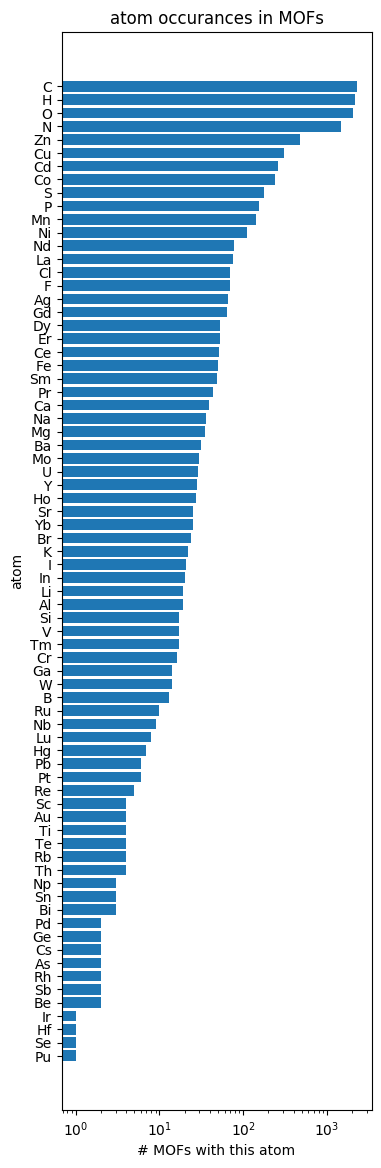

PyObject Text(0.5, 1, 'atom occurances in MOFs')

In [13]:
figure(figsize=(4, 14))
barh(1:nrow(df_species_occurance), df_species_occurance[:, :nb_mofs])
yticks(1:nrow(df_species_occurance), df_species_occurance[:, :atom])
xlabel("# MOFs with this atom")
ylabel("atom")
xscale("log")
title("atom occurances in MOFs")

### atom <--> integer mapping for one-hot encoding

sort my occurance

In [14]:
sort!(df_species_occurance, :nb_mofs, rev=true)
const ATOMS = deepcopy(df_species_occurance[:, :atom])
ATOMS

74-element Array{Symbol,1}:
 :C 
 :H 
 :O 
 :N 
 :Zn
 :Cu
 :Cd
 :Co
 :S 
 :P 
 :Mn
 :Ni
 :Nd
 ⋮  
 :Np
 :Be
 :Sb
 :Rh
 :As
 :Cs
 :Ge
 :Pd
 :Pu
 :Se
 :Hf
 :Ir

In [15]:
const ATOM_TO_INT = Dict{Symbol, Int}(a => i for (i, a) in enumerate(ATOMS))
ATOM_TO_INT

Dict{Symbol,Int64} with 74 entries:
  :Cl => 15
  :Al => 39
  :Re => 54
  :Be => 64
  :Cr => 44
  :Na => 26
  :Sb => 65
  :Ni => 12
  :S  => 9
  :Ru => 48
  :Tm => 41
  :W  => 45
  :Nd => 13
  :O  => 3
  :Th => 55
  :F  => 16
  :Co => 8
  :Gd => 18
  :Rh => 66
  :Pu => 71
  :Ca => 25
  :N  => 4
  :Yb => 33
  :As => 67
  :Se => 72
  ⋮   => ⋮

### write graph structure, edge features, node features, and node labels to file for each MOF

In [16]:
isdir("graphs") ? nothing : mkdir("graphs")
metals = [:Li, :Na, :K, :Rb, :Cs, :Fr, #Alkali metals
          :Be, :Mg, :Ca, :Sr, :Ba, :Ra, #Alkaline earth metals
          :Sc, :Ti, :V, :Cr, :Mn, :Fe, :Co, :Ni, :Cu, :Zn,
          :Y, :Zr, :Nb, :Mo, :Tc, :Ru, :Rh, :Pd, :Ag, :Cd,
          :Hf, :Ta, :W, :Re, :Os, :Ir, :Pt, :Au, :Hg,
          :Rf, :Db, :Sg, :Bh, :Hs, :Cn, #Transition metals
          :Al, :Ga, :In, :Sn, :Tl, :Pb, :Bi, :Po, :Fl, #Post-transition metals
          :La, :Ce, :Pr, :Nd, :Pm, :Sm, :Eu, :Gd, :Tb, :Dy, :Ho, :Er, :Tm, :Yb, :Lu, #Lanthanoids
          :Ac, :Th, :Pa, :U, :Np, :Pu, :Am, :Cm, :Bk, :Cf, :Es, :Fm, :Md, :No, :Lr] #Actinoids

86-element Array{Symbol,1}:
 :Li
 :Na
 :K 
 :Rb
 :Cs
 :Fr
 :Be
 :Mg
 :Ca
 :Sr
 :Ba
 :Ra
 :Sc
 ⋮  
 :U 
 :Np
 :Pu
 :Am
 :Cm
 :Bk
 :Cf
 :Es
 :Fm
 :Md
 :No
 :Lr

In [18]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(xtalnames)]
metal_coordination = Dict(xtal => [] for xtal in metals)
KEEP_TRACK_OF_COORDINATION = true

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("graphs", xtalname * "_node_features.npy"), x_ν)

    ###
    #    node labels (the charges)
    ###
    y_ν = deepcopy(crystal.charges.q)
    npzwrite(joinpath("graphs", xtalname * "_node_labels.npy"), y_ν)
    @assert length(y_ν) == size(x_ν)[1]

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("graphs", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
            
    if KEEP_TRACK_OF_COORDINATION
        for (i, a) in enumerate(crystal.atoms.species)
            if a in metals
                push!(metal_coordination[a], length(neighbors(crystal.bonds, i)))
            end
        end
    end
end

writedlm(open("list_of_crystals.txt", "w"), xtalnames[keep_xtal])

┌ Info: making edge list zero-based indexed for Python
└ @ Main In[18]:1


Progress:   1%|▎                                        |  ETA: 0:12:08

┌ Warning: atom 3 = K in POKXIX_clean.cif is over coordinated (connected to 11.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = POKXIX_clean.cif
└ @ Main In[18]:25


Progress:   4%|█▋                                       |  ETA: 0:09:00

┌ Warning: hydrogen atom 18 in VAYDOQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = VAYDOQ_clean.cif
└ @ Main In[18]:25


Progress:   4%|█▊                                       |  ETA: 0:08:52

┌ Warning: hydrogen atom 31 in BORBEQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = BORBEQ_clean.cif
└ @ Main In[18]:25


Progress:   6%|██▋                                      |  ETA: 0:07:49

┌ Warning: hydrogen atom 10 in BONWIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = BONWIL_clean.cif
└ @ Main In[18]:25


Progress:   7%|██▊                                      |  ETA: 0:07:50

┌ Warning: carbon atom 102 in KOJZAL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:178
┌ Warning: throwing out 
│   crystal.name = KOJZAL_clean.cif
└ @ Main In[18]:25


Progress:   9%|███▋                                     |  ETA: 0:07:25

┌ Warning: atom 1 = La in PIHWAG_clean.cif is over coordinated (connected to 11.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = PIHWAG_clean.cif
└ @ Main In[18]:25


Progress:   9%|███▊                                     |  ETA: 0:07:21

┌ Warning: hydrogen atom 8 in ISEQIH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = ISEQIH_clean.cif
└ @ Main In[18]:25


Progress:  11%|████▌                                    |  ETA: 0:07:29

┌ Warning: hydrogen atom 14 in FAZZEM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = FAZZEM_clean.cif
└ @ Main In[18]:25


Progress:  13%|█████▎                                   |  ETA: 0:07:19

┌ Warning: hydrogen atom 17 in HEZSAG_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = HEZSAG_clean.cif
└ @ Main In[18]:25


Progress:  14%|█████▌                                   |  ETA: 0:07:23

┌ Warning: hydrogen atom 28 in XAWZOM_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = XAWZOM_clean.cif
└ @ Main In[18]:25


Progress:  16%|██████▋                                  |  ETA: 0:07:11

┌ Warning: carbon atom 29 in MOGXUB_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:178
┌ Warning: throwing out 
│   crystal.name = MOGXUB_clean.cif
└ @ Main In[18]:25


Progress:  20%|████████▍                                |  ETA: 0:07:02

Voronoi problems with HAFTOZ_clean.cif
┌ Warning: atom 1 = Ni in HAFTOZ_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = HAFTOZ_clean.cif
└ @ Main In[18]:25


Progress:  21%|████████▌                                |  ETA: 0:06:58

┌ Warning: carbon atom 109 in NATXOW_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:178
┌ Warning: throwing out 
│   crystal.name = NATXOW_clean.cif
└ @ Main In[18]:25


Progress:  21%|████████▊                                |  ETA: 0:06:53

┌ Warning: hydrogen atom 5 in ZERNAN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = ZERNAN_clean.cif
└ @ Main In[18]:25


Progress:  23%|█████████▎                               |  ETA: 0:06:45

Voronoi problems with COF-5.cif


Progress:  24%|█████████▊                               |  ETA: 0:06:38

Voronoi problems with QUQPOI_clean.cif
┌ Warning: atom 1 = Zn in QUQPOI_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = QUQPOI_clean.cif
└ @ Main In[18]:25


Progress:  26%|██████████▌                              |  ETA: 0:06:27

┌ Warning: atom 3 = Ce in PURQID_clean.cif is over coordinated (connected to 12.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = PURQID_clean.cif
└ @ Main In[18]:25


Progress:  26%|██████████▋                              |  ETA: 0:06:25

┌ Warning: hydrogen atom 6 in ZERNOB_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = ZERNOB_clean.cif
└ @ Main In[18]:25


Progress:  28%|███████████▌                             |  ETA: 0:06:12

┌ Warning: hydrogen atom 9 in FIMXUW_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = FIMXUW_clean.cif
└ @ Main In[18]:25


Progress:  35%|██████████████▌                          |  ETA: 0:05:38

┌ Warning: hydrogen atom 10 in SUHHOT_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = SUHHOT_clean.cif
└ @ Main In[18]:25


Progress:  36%|██████████████▋                          |  ETA: 0:05:39

┌ Warning: atom 9 = Th in DAHTIQ_clean.cif is over coordinated (connected to 15.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = DAHTIQ_clean.cif
└ @ Main In[18]:25


Progress:  38%|███████████████▊                         |  ETA: 0:05:22

┌ Warning: hydrogen atom 16 in UJARAZ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = UJARAZ_clean.cif
└ @ Main In[18]:25


Progress:  42%|█████████████████▏                       |  ETA: 0:05:01

┌ Warning: carbon atom 89 in HITXUE.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:178
┌ Warning: throwing out 
│   crystal.name = HITXUE.cif
└ @ Main In[18]:25


Progress:  45%|██████████████████▎                      |  ETA: 0:04:44

┌ Warning: atom 1 = Ce in PIJROR_clean.cif is over coordinated (connected to 11.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = PIJROR_clean.cif
└ @ Main In[18]:25


Progress:  45%|██████████████████▌                      |  ETA: 0:04:41

┌ Warning: hydrogen atom 11 in UXABUR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = UXABUR_clean.cif
└ @ Main In[18]:25


Progress:  45%|██████████████████▌                      |  ETA: 0:04:41

Voronoi problems with DUXZIG01_clean.cif
┌ Warning: atom 1 = Zn in DUXZIG01_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = DUXZIG01_clean.cif
└ @ Main In[18]:25


Progress:  46%|███████████████████                      |  ETA: 0:04:37

┌ Warning: atom 23 = H in JEMQEY_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = JEMQEY_clean.cif
└ @ Main In[18]:25


Progress:  49%|████████████████████▎                    |  ETA: 0:04:22

┌ Warning: hydrogen atom 17 in TEWGEJ01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = TEWGEJ01_clean.cif
└ @ Main In[18]:25


Progress:  50%|████████████████████▍                    |  ETA: 0:04:22

┌ Warning: carbon atom 125 in WAZQUL_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:178
┌ Warning: throwing out 
│   crystal.name = WAZQUL_clean.cif
└ @ Main In[18]:25


Progress:  50%|████████████████████▍                    |  ETA: 0:04:21

Voronoi problems with KECRAL10_clean.cif
┌ Warning: atom 1 = Cd in KECRAL10_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = KECRAL10_clean.cif
└ @ Main In[18]:25


Progress:  50%|████████████████████▌                    |  ETA: 0:04:19

┌ Warning: hydrogen atom 9 in VASKOR_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = VASKOR_clean.cif
└ @ Main In[18]:25


Progress:  50%|████████████████████▋                    |  ETA: 0:04:17

┌ Warning: carbon atom 125 in WAZRAS_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:178
┌ Warning: throwing out 
│   crystal.name = WAZRAS_clean.cif
└ @ Main In[18]:25


Progress:  51%|█████████████████████                    |  ETA: 0:04:12

┌ Warning: carbon atom 27 in YEWWUU_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:178
┌ Warning: throwing out 
│   crystal.name = YEWWUU_clean.cif
└ @ Main In[18]:25


Progress:  54%|██████████████████████                   |  ETA: 0:04:00

┌ Warning: atom 81 = O in NAJGAH_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = NAJGAH_clean.cif
└ @ Main In[18]:25


Progress:  54%|██████████████████████                   |  ETA: 0:03:59

┌ Warning: hydrogen atom 5 in ZERNUH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = ZERNUH_clean.cif
└ @ Main In[18]:25


Progress:  57%|███████████████████████▌                 |  ETA: 0:03:41

┌ Warning: hydrogen atom 36 in WENKEH_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = WENKEH_clean.cif
└ @ Main In[18]:25


Progress:  61%|████████████████████████▉                |  ETA: 0:03:24

┌ Warning: carbon atom 79 in MOGYAI_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:178
┌ Warning: throwing out 
│   crystal.name = MOGYAI_clean.cif
└ @ Main In[18]:25


Progress:  61%|█████████████████████████                |  ETA: 0:03:22

┌ Warning: hydrogen atom 20 in QARTEK_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = QARTEK_clean.cif
└ @ Main In[18]:25


Progress:  65%|██████████████████████████▌              |  ETA: 0:03:04

┌ Warning: carbon atom 23 in LIQGEY_clean.cif is bonded to more than four atoms!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:178
┌ Warning: throwing out 
│   crystal.name = LIQGEY_clean.cif
└ @ Main In[18]:25


Progress:  67%|███████████████████████████▌             |  ETA: 0:02:52

┌ Warning: hydrogen atom 10 in PAMHES01_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = PAMHES01_clean.cif
└ @ Main In[18]:25


Progress:  68%|███████████████████████████▉             |  ETA: 0:02:48

┌ Warning: hydrogen atom 5 in PAMGIV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = PAMGIV_clean.cif
└ @ Main In[18]:25


Progress:  74%|██████████████████████████████▌          |  ETA: 0:02:14

┌ Warning: hydrogen atom 7 in QOPHEI_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = QOPHEI_clean.cif
└ @ Main In[18]:25


Progress:  75%|██████████████████████████████▉          |  ETA: 0:02:10

┌ Warning: hydrogen atom 7 in LETRIN_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = LETRIN_clean.cif
└ @ Main In[18]:25


Progress:  77%|███████████████████████████████▋         |  ETA: 0:01:59

┌ Warning: hydrogen atom 10 in BEXTUV_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = BEXTUV_clean.cif
└ @ Main In[18]:25


Progress:  79%|████████████████████████████████▍        |  ETA: 0:01:49

Voronoi problems with FUNCEX_clean.cif
┌ Warning: atom 1 = Zn in FUNCEX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = FUNCEX_clean.cif
└ @ Main In[18]:25


Progress:  79%|████████████████████████████████▌        |  ETA: 0:01:48

Voronoi problems with TEDGOA_clean.cif
┌ Warning: atom 1 = Zn in TEDGOA_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = TEDGOA_clean.cif
└ @ Main In[18]:25


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:01:32

┌ Warning: atom 1 = Ce in YURJUR_clean.cif is over coordinated (connected to 12.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = YURJUR_clean.cif
└ @ Main In[18]:25


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:01:09

┌ Warning: atom 285 = C in RIDKOE.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = RIDKOE.cif
└ @ Main In[18]:25


Progress:  87%|███████████████████████████████████▉     |  ETA: 0:01:06

Voronoi problems with FUNBOG_clean.cif
┌ Warning: atom 1 = Zn in FUNBOG_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = FUNBOG_clean.cif
└ @ Main In[18]:25


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:54

┌ Warning: hydrogen atom 9 in OXAZIX_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = OXAZIX_clean.cif
└ @ Main In[18]:25


Progress:  90%|█████████████████████████████████████▏   |  ETA: 0:00:50

┌ Warning: atom 35 = H in RUVMAX_clean.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = RUVMAX_clean.cif
└ @ Main In[18]:25


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:48

┌ Warning: hydrogen atom 9 in VEHRIL_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = VEHRIL_clean.cif
└ @ Main In[18]:25


Progress:  91%|█████████████████████████████████████▌   |  ETA: 0:00:45

┌ Warning: hydrogen atom 35 in UDANAQ_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = UDANAQ_clean.cif
└ @ Main In[18]:25


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:32

┌ Warning: atom 129 = H in ZEKROY.cif is not bonded to any other atom.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:161
┌ Warning: throwing out 
│   crystal.name = ZEKROY.cif
└ @ Main In[18]:25


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:22

┌ Warning: atom 1 = Cs in NEVGIE.cif is over coordinated (connected to 11.
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:168
┌ Warning: throwing out 
│   crystal.name = NEVGIE.cif
└ @ Main In[18]:25


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:06

┌ Warning: hydrogen atom 10 in ASALIP_clean.cif is bonded to more than one atom!
└ @ PorousMaterials /home/sturlusa/my_projects/PorousMaterials.jl/src/bonds.jl:173
┌ Warning: throwing out 
│   crystal.name = ASALIP_clean.cif
└ @ Main In[18]:25


Progress: 100%|█████████████████████████████████████████| Time: 0:08:46


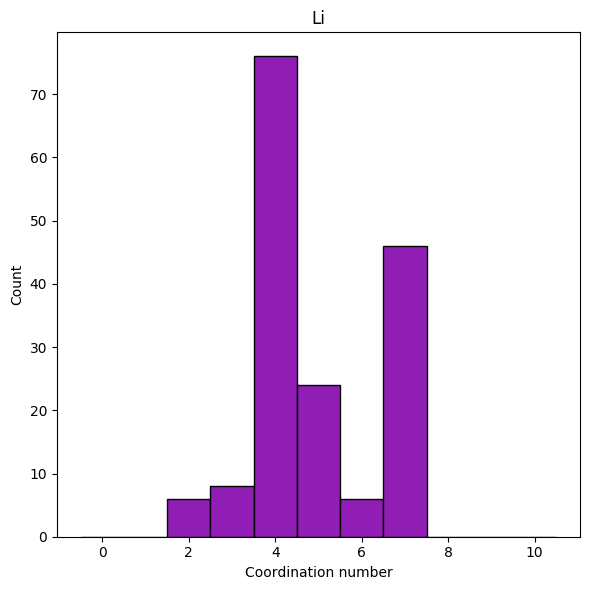

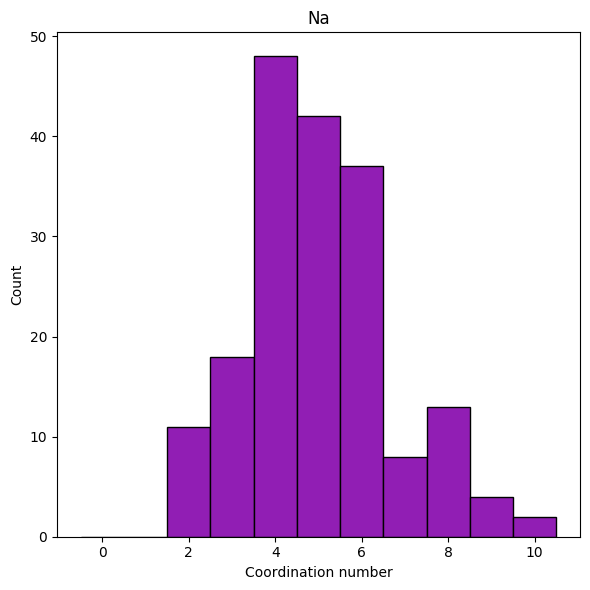

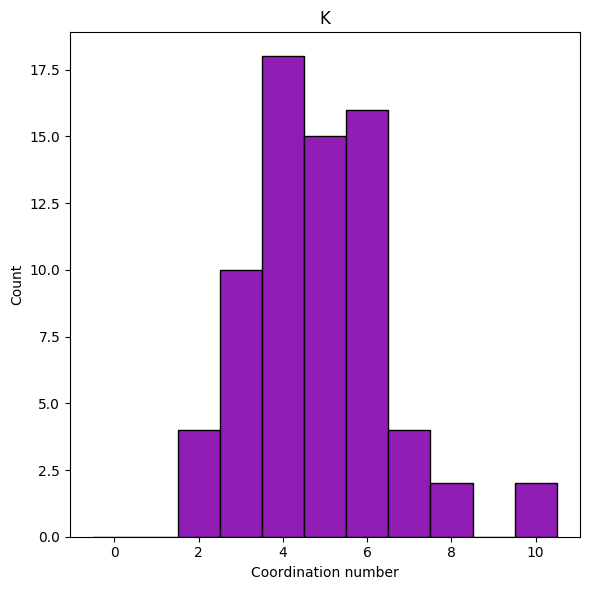

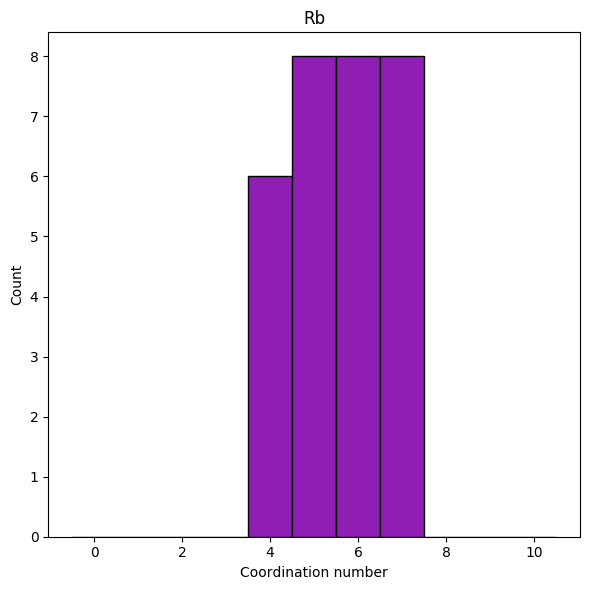

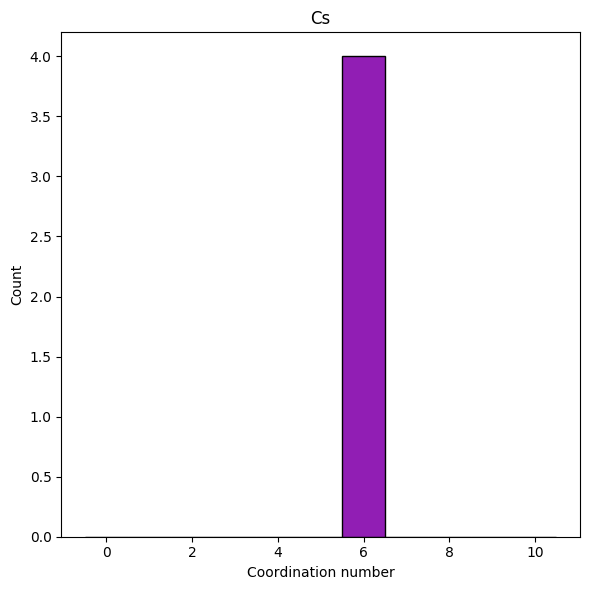

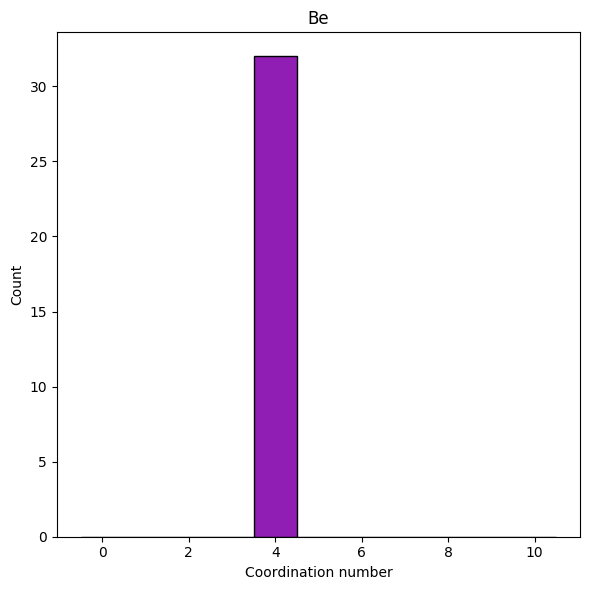

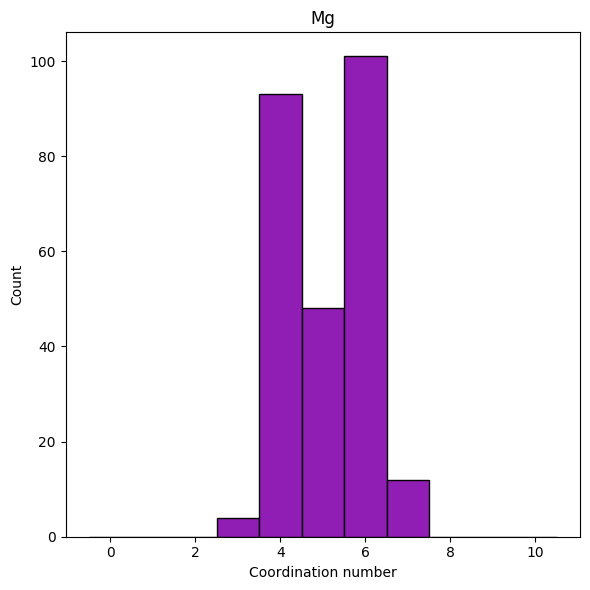

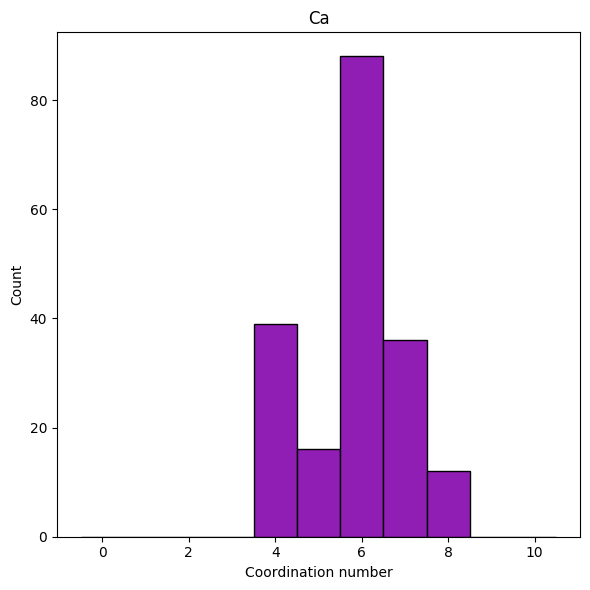

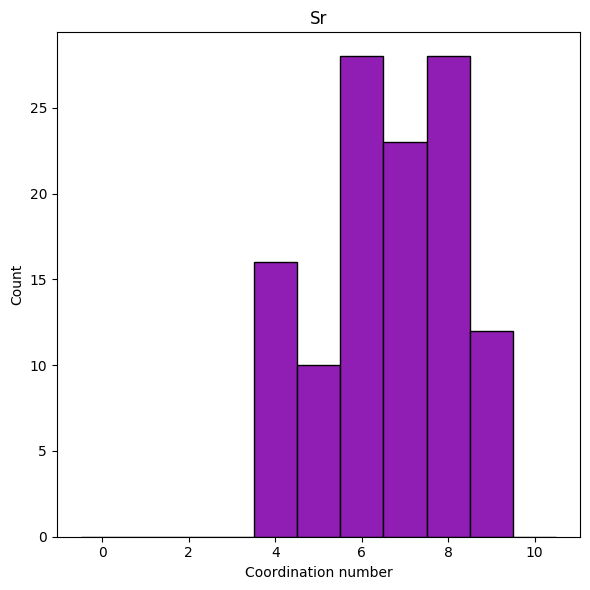

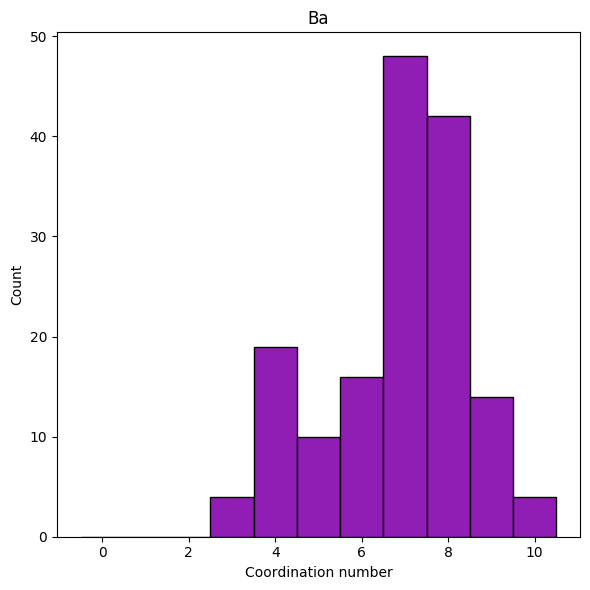

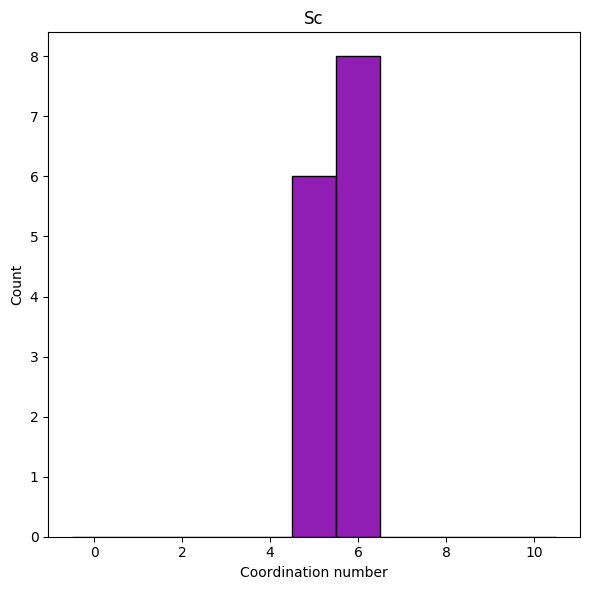

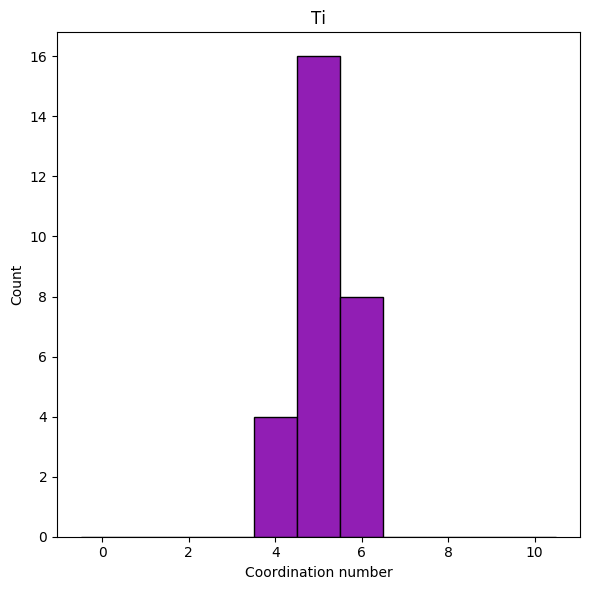

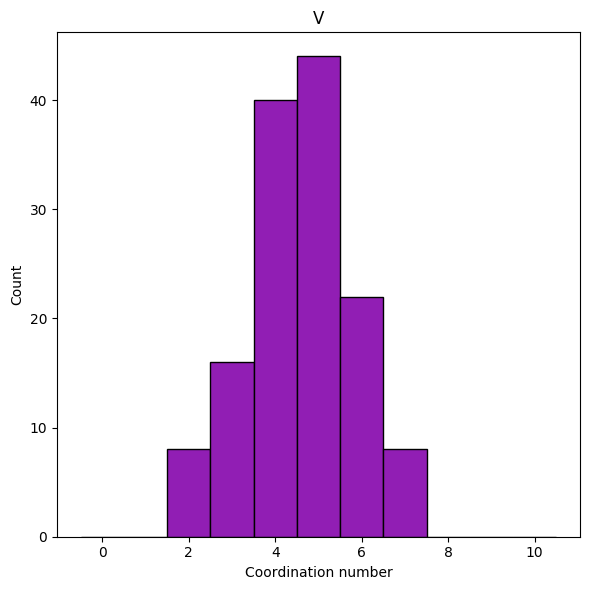

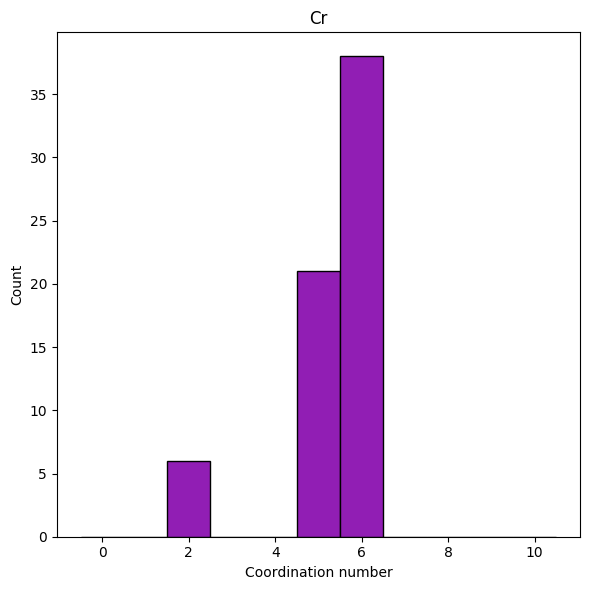

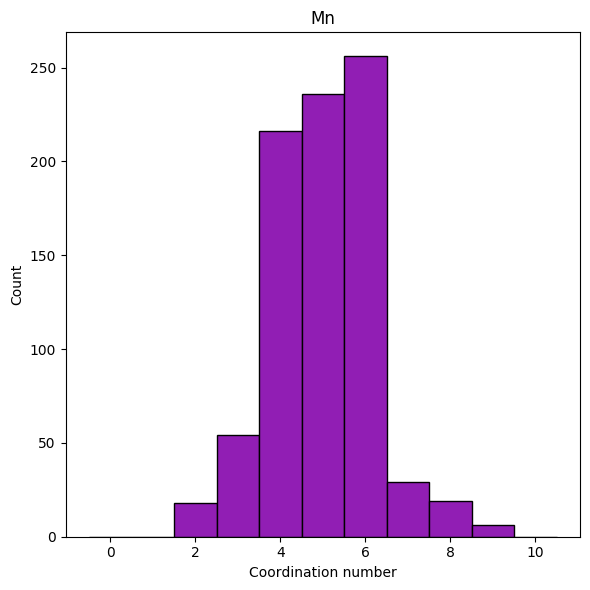

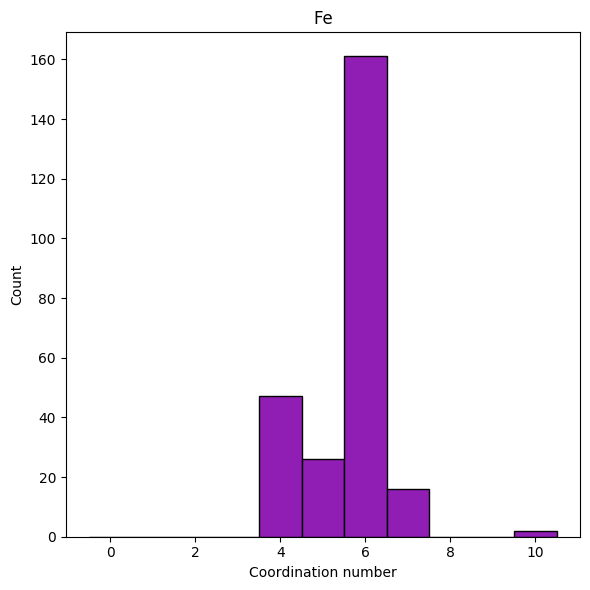

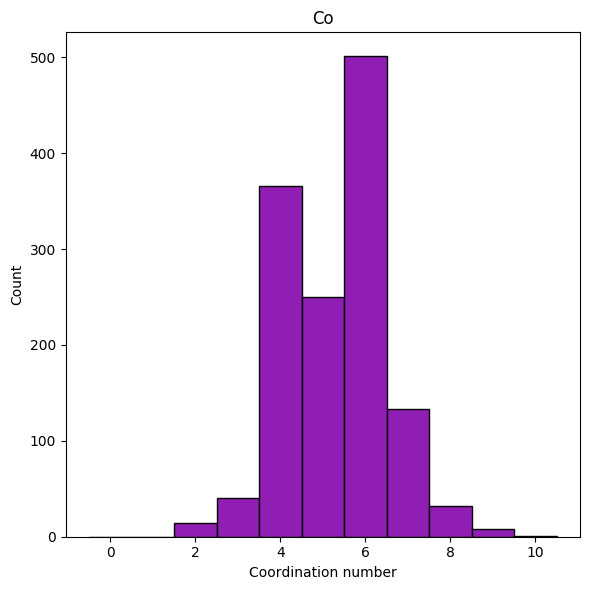

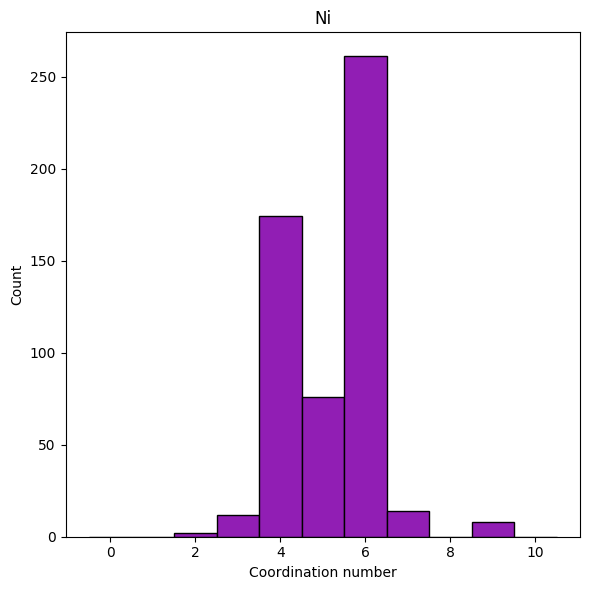

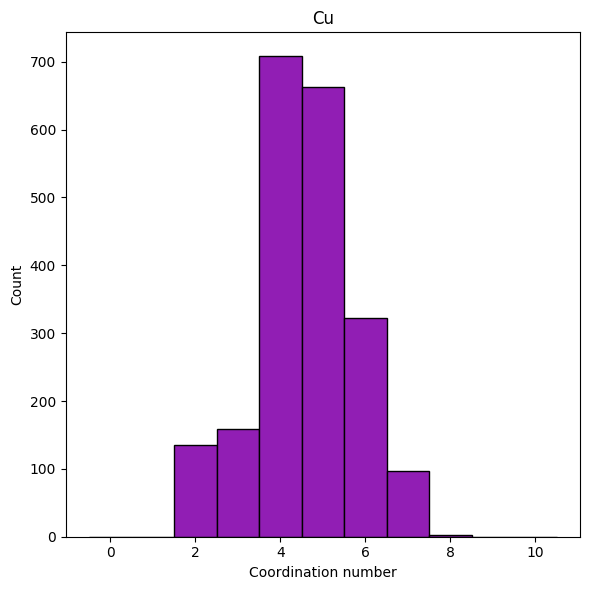

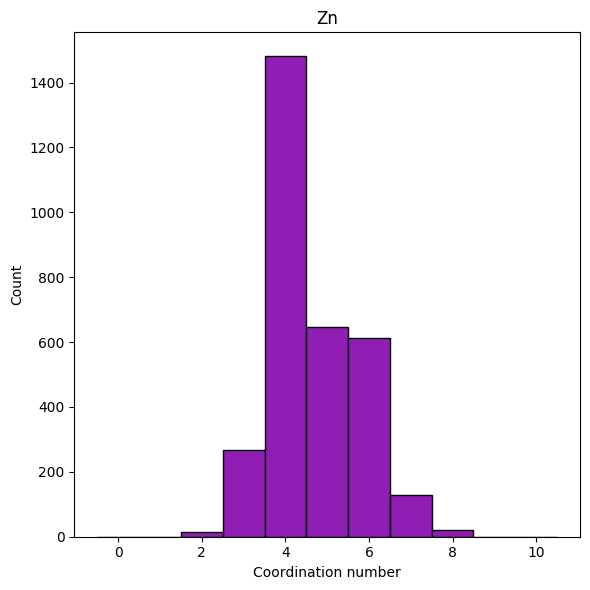

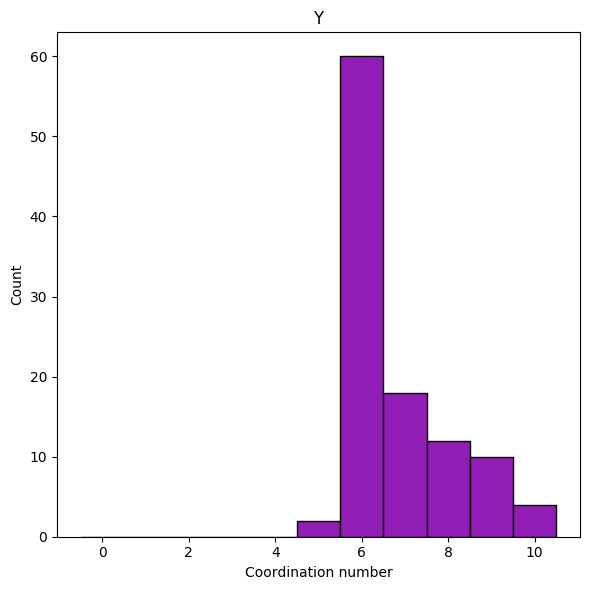

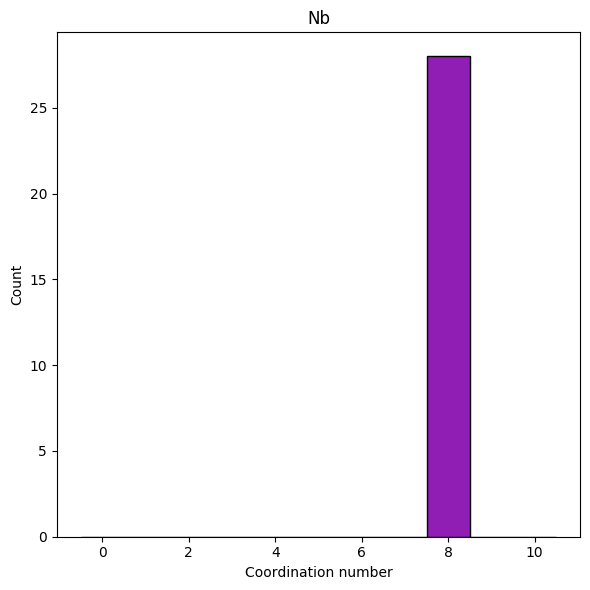

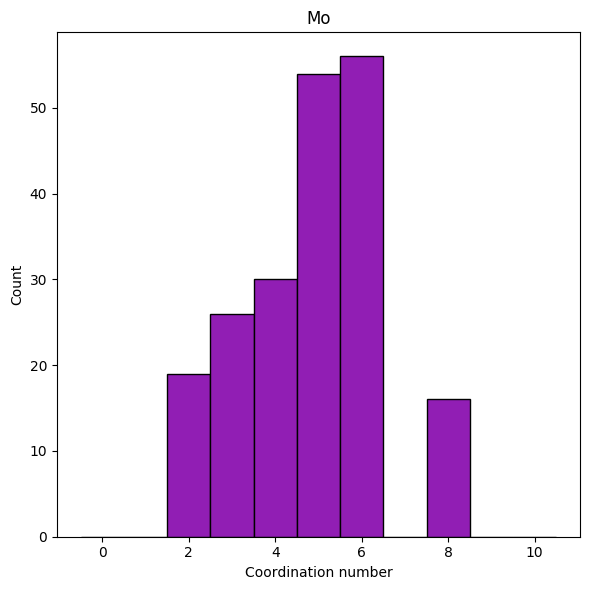

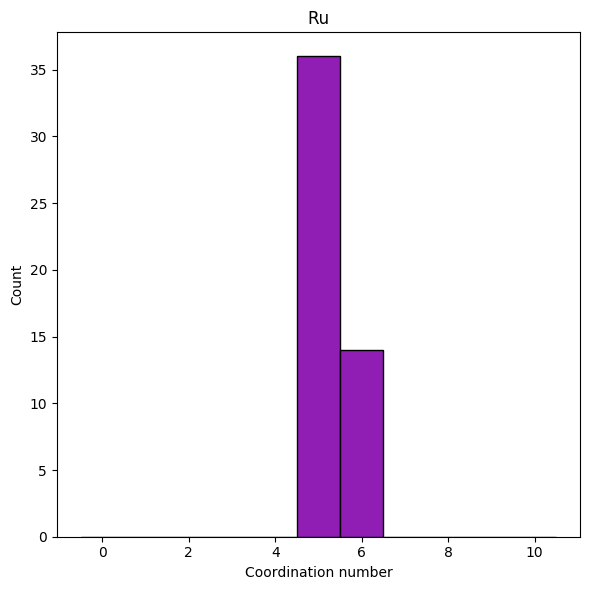

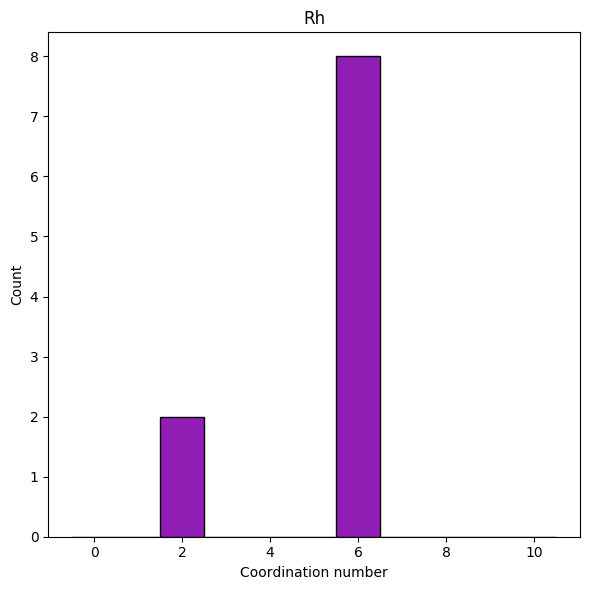

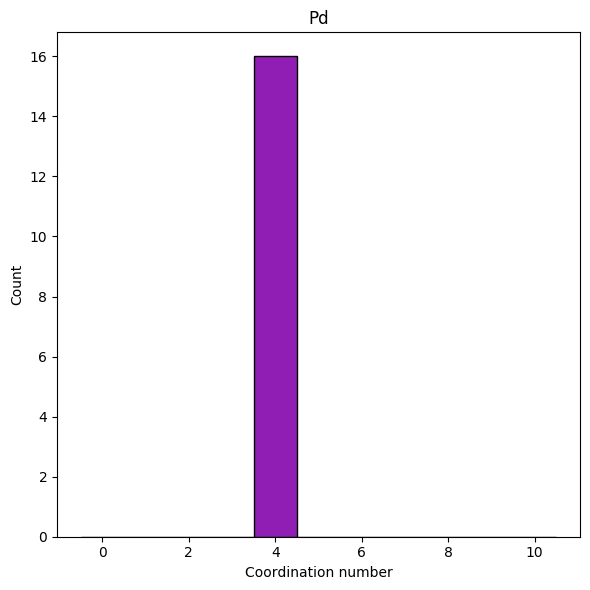

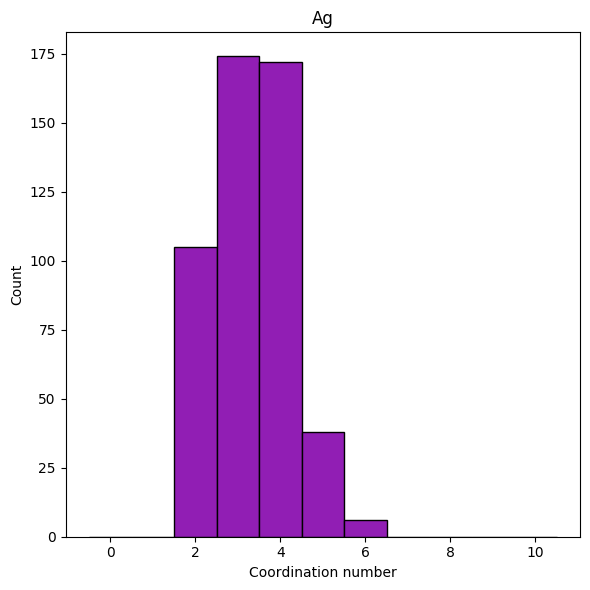

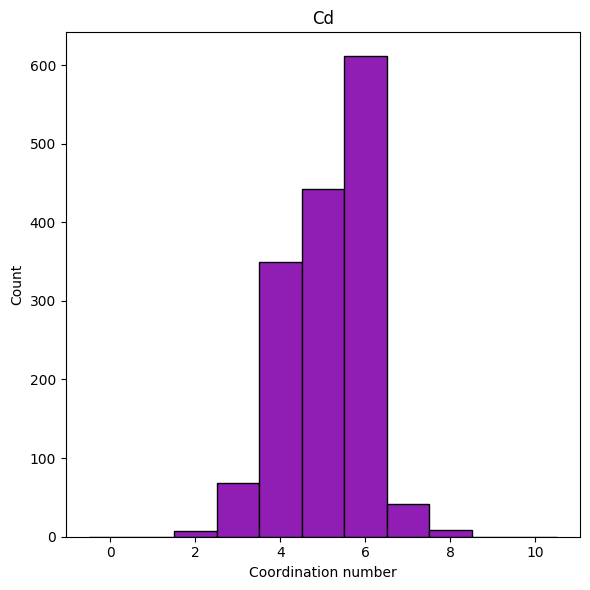

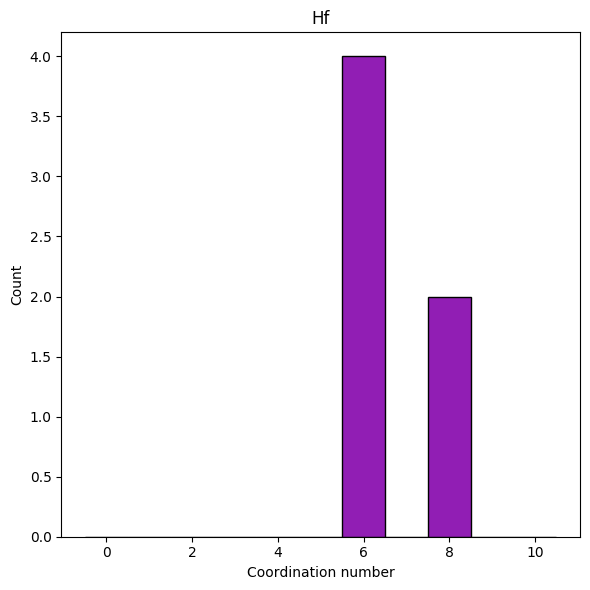

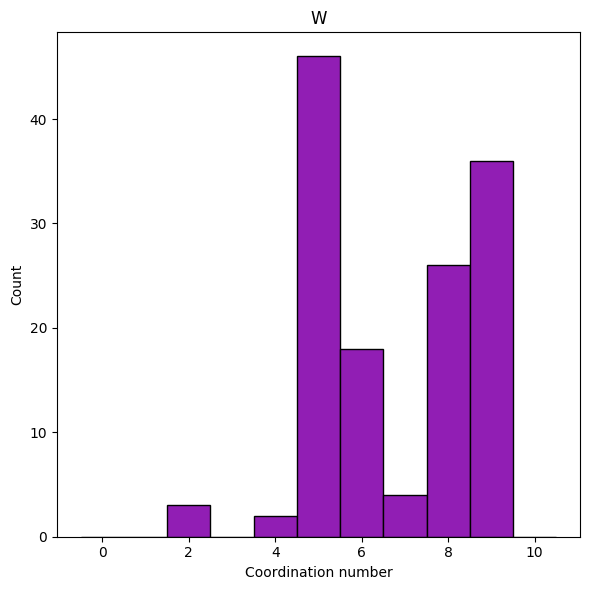

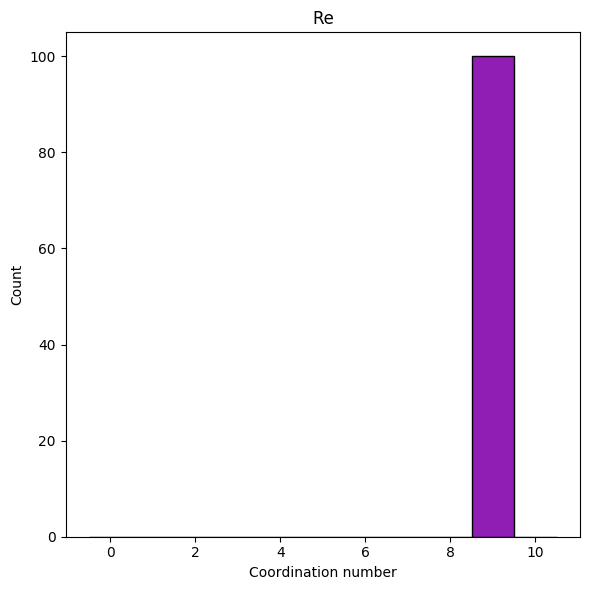

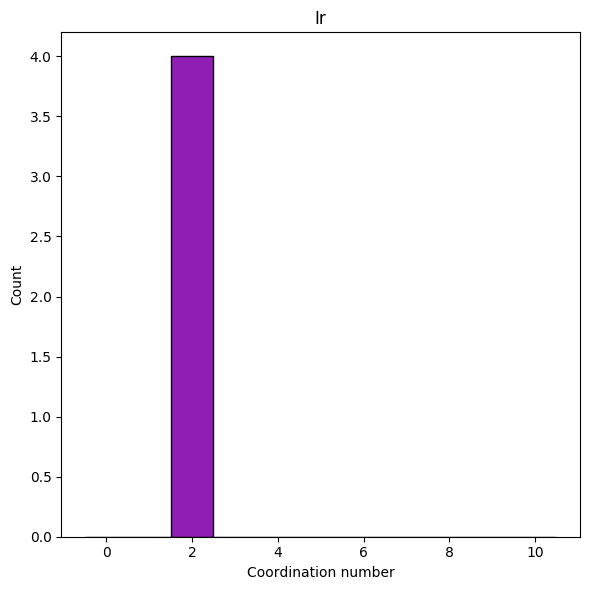

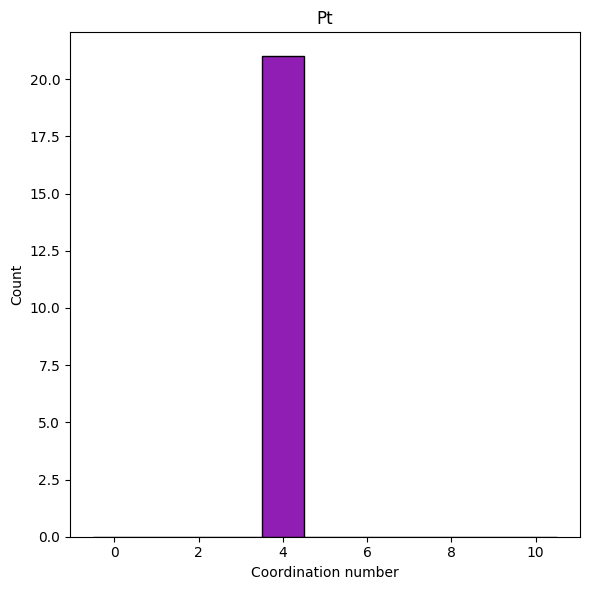

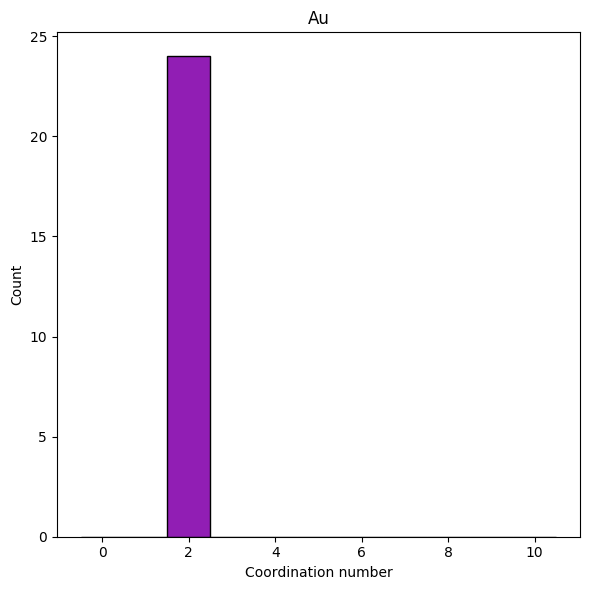

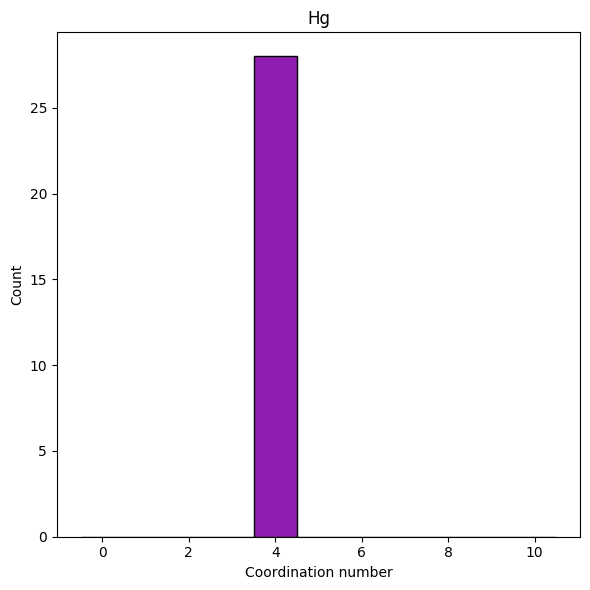

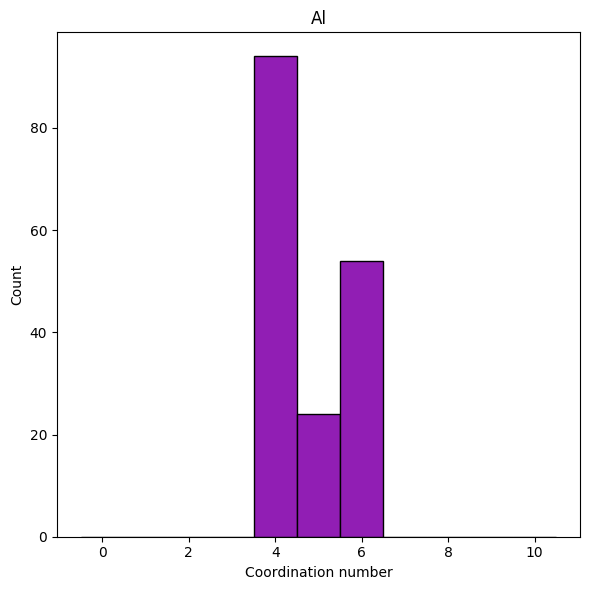

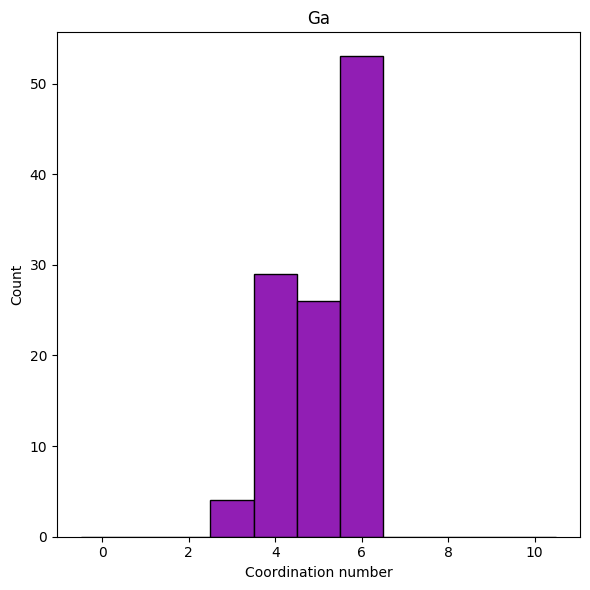

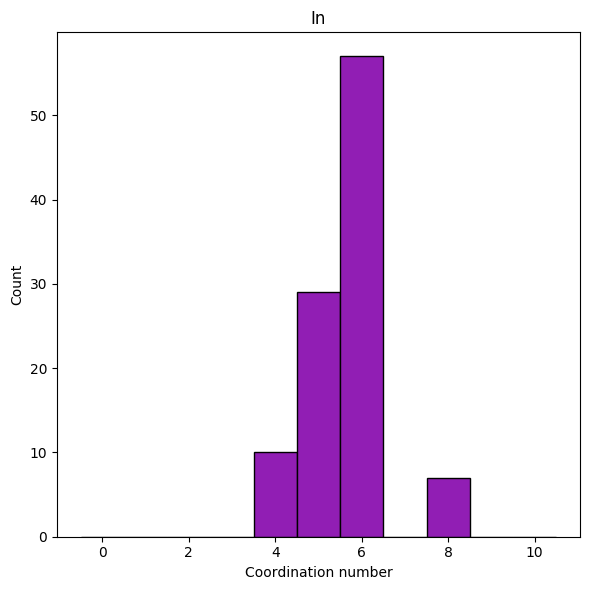

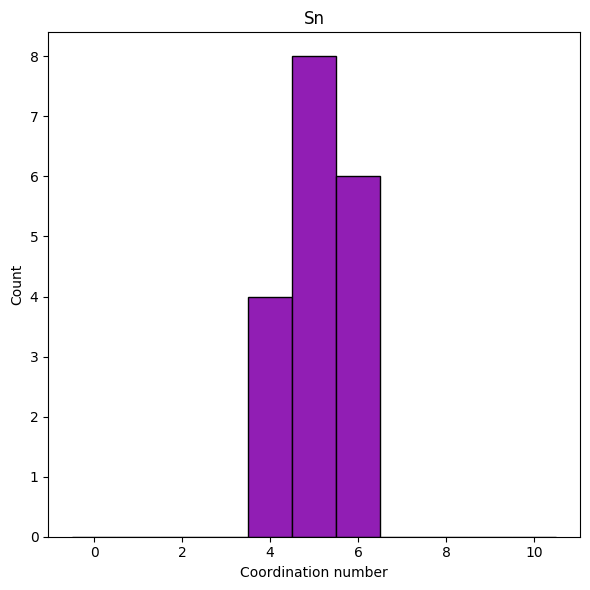

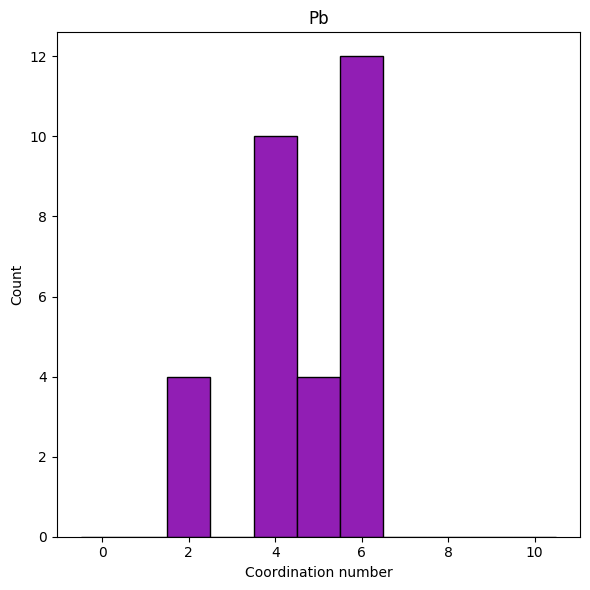

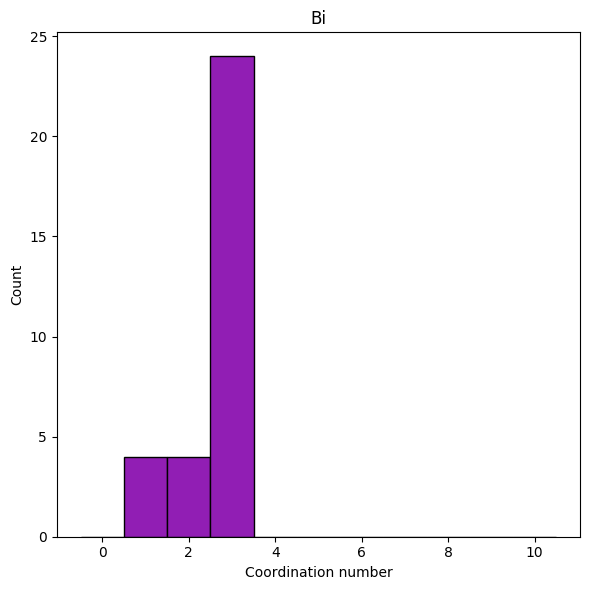

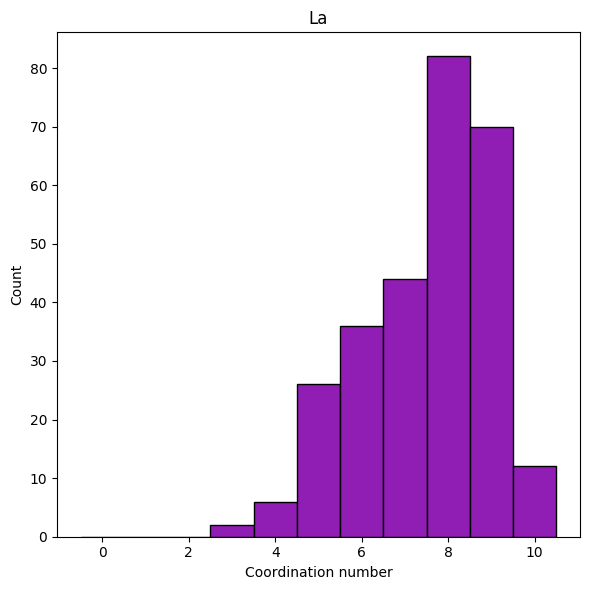

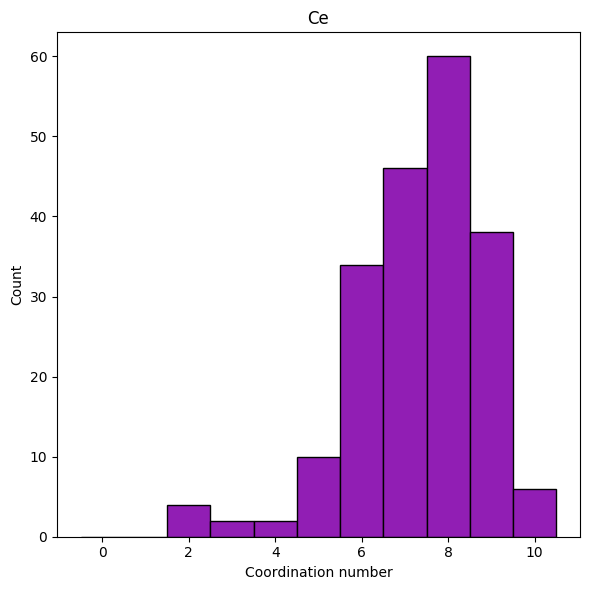

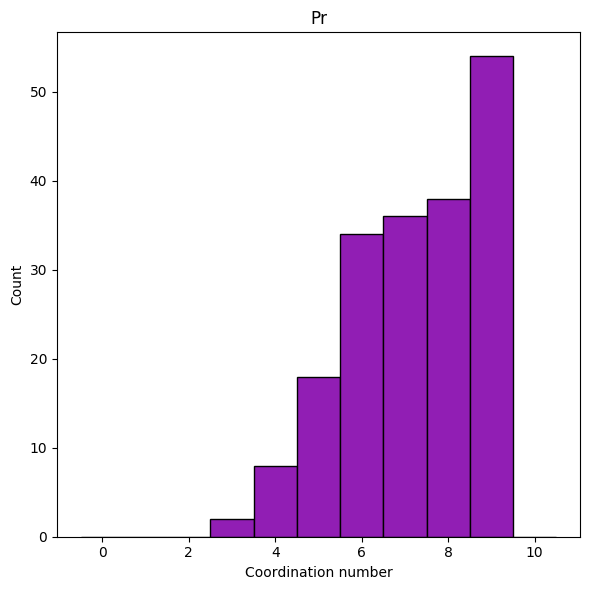

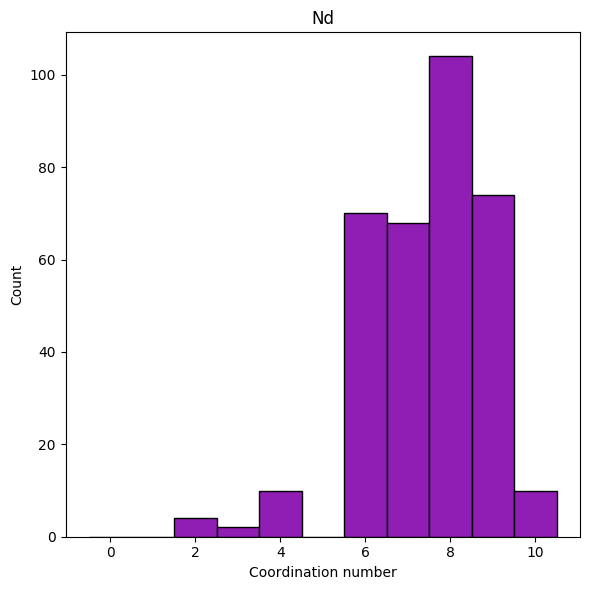

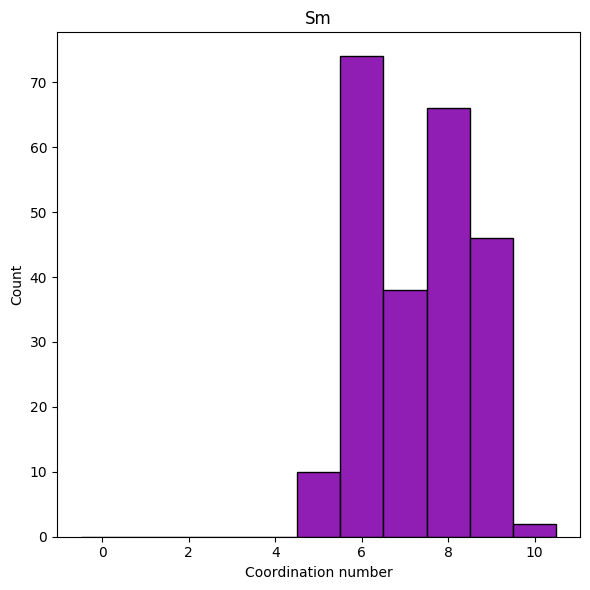

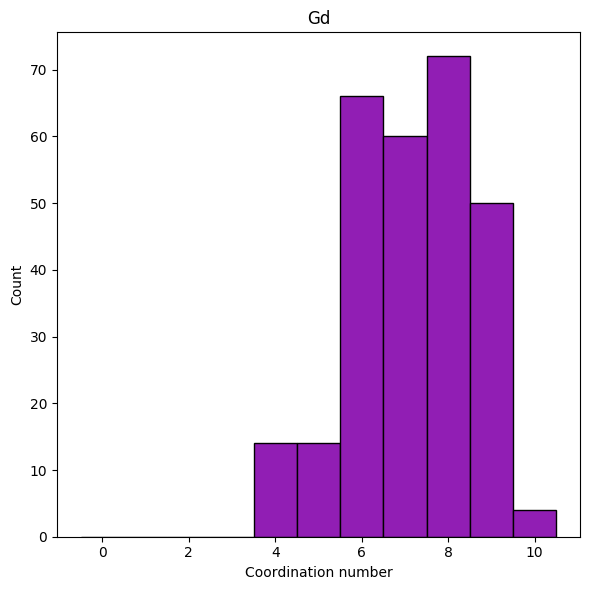

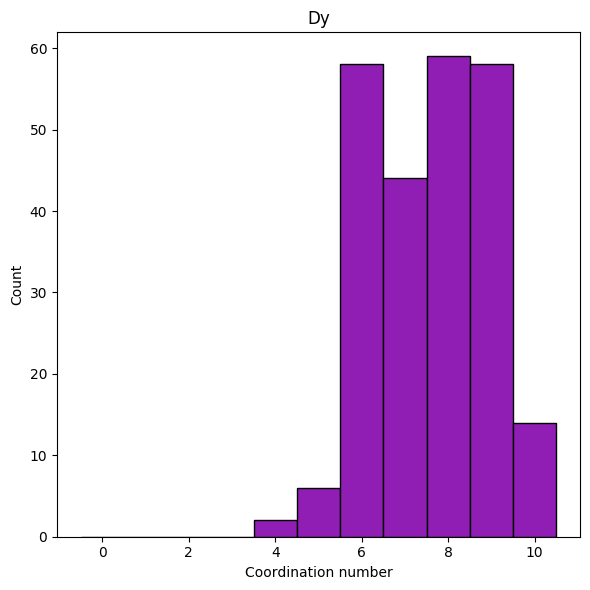

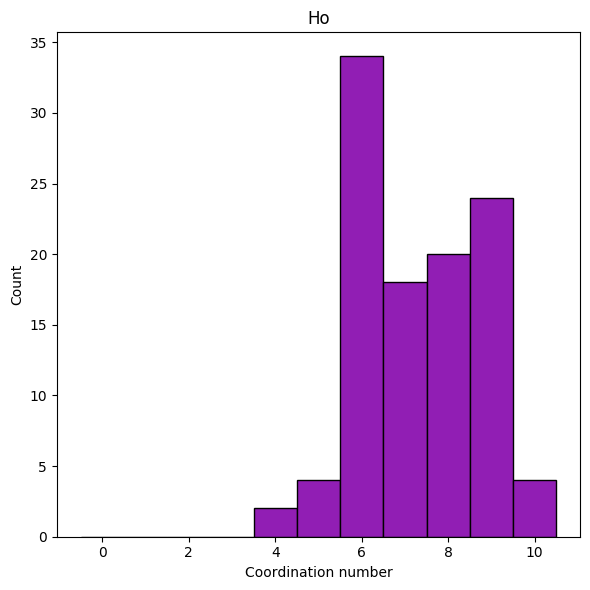

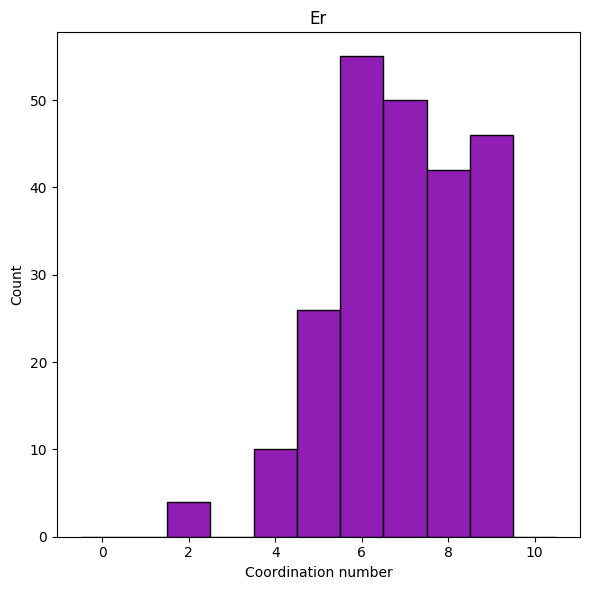

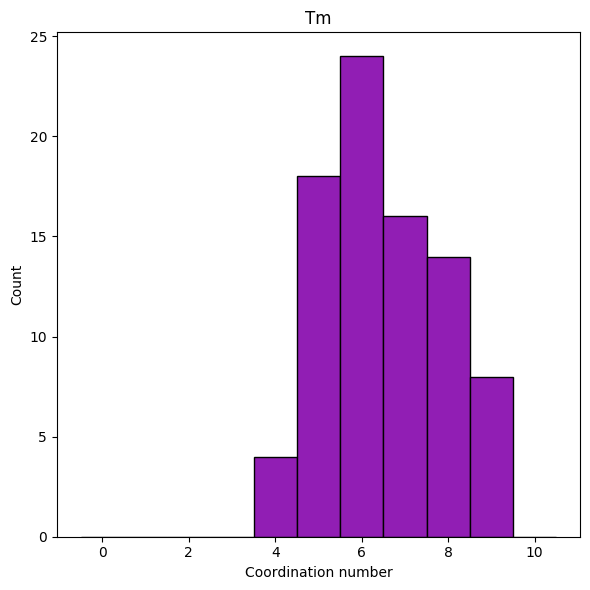

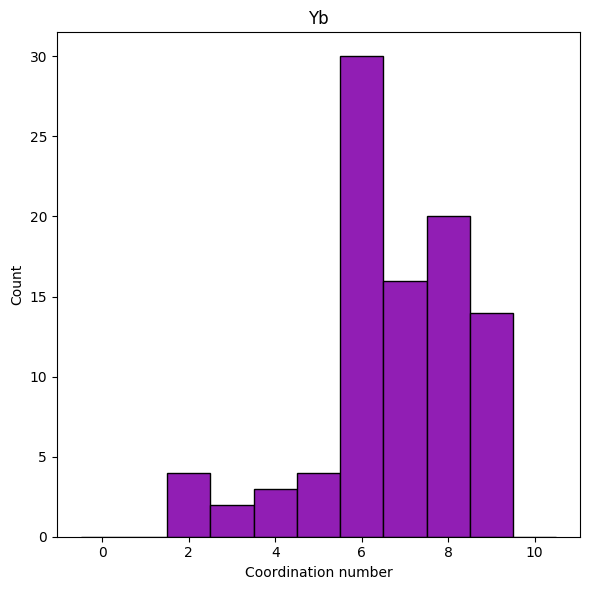

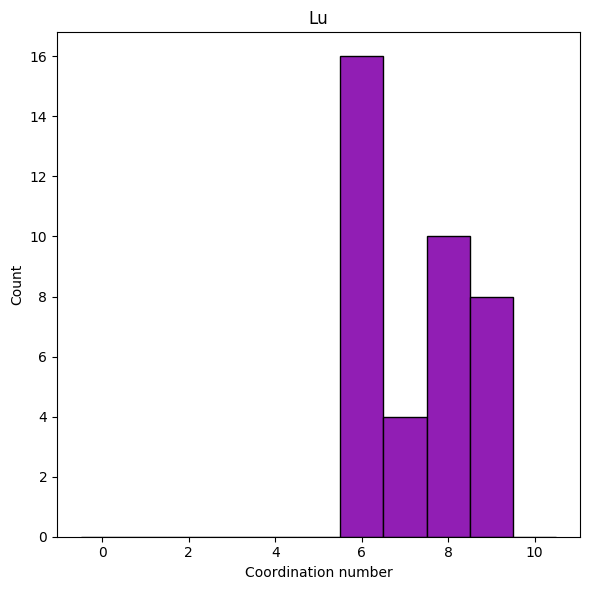

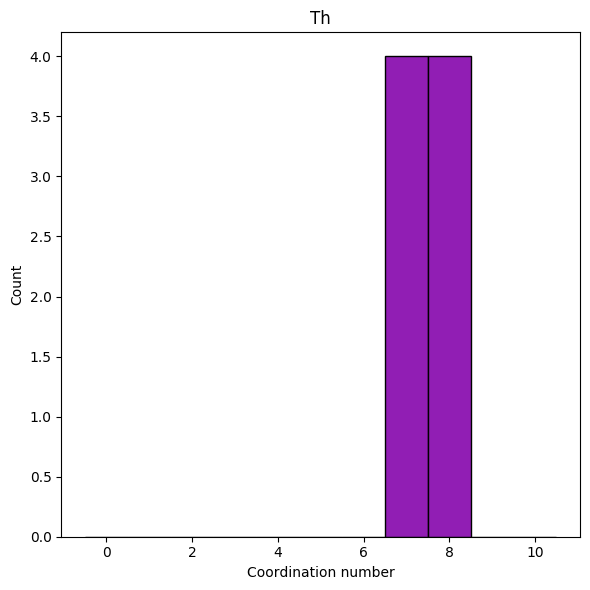

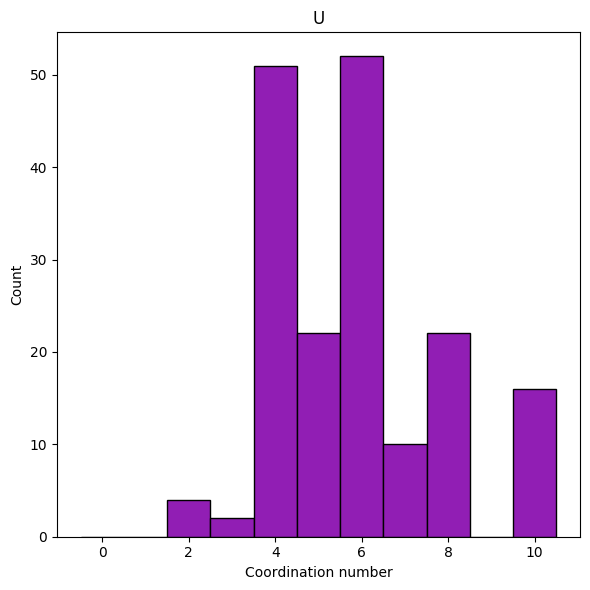

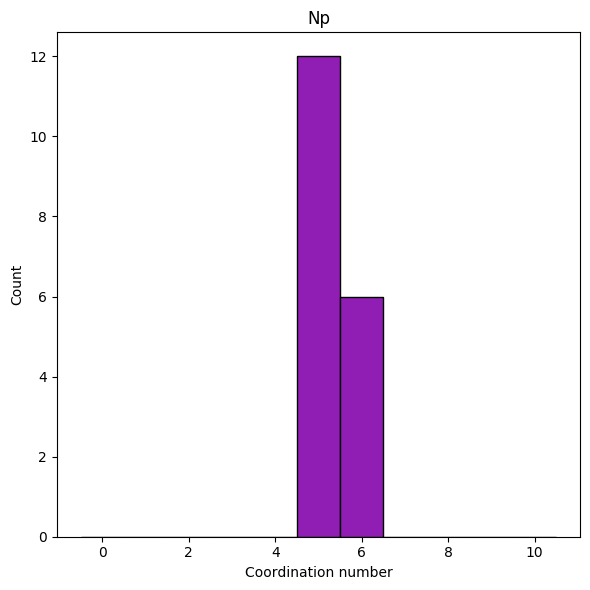

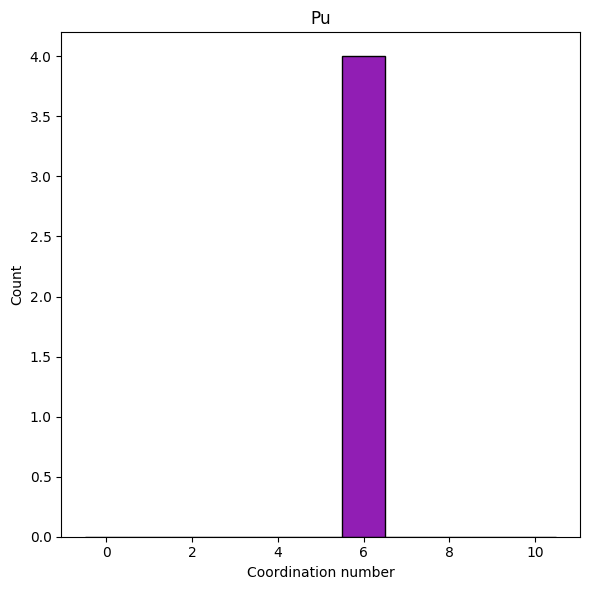

In [26]:
if KEEP_TRACK_OF_COORDINATION
    for metal in metals
        if length(metal_coordination[metal]) == 0
            continue
        end
        fig, ax = plt.subplots(figsize=(6,6))
        ax.hist(metal_coordination[metal], bins=collect(0:11), align="left", fc="#911eb4", ec="k")
        ax.set_xlabel("Coordination number")
        ax.set_ylabel("Count")
        ax.set_title(String(metal))
        plt.tight_layout()
        plt.show()
    end
end

In [ ]:
@info "making edge list zero-based indexed for Python"

nb_graphs = [0 for i = 1:length(xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    crystal = replicate(crystal, (2,2,2))
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
            
    nb_graphs[i_xtal] = length(connected_components(crystal.bonds))
end

In [ ]:
sorted_list_of_components = sortperm(nb_graphs, rev=true)
for idx in sorted_list_of_components
    @printf("%s\t%d\n", xtalnames[idx], nb_graphs[idx])
end
#xtalnames[sorted_list_of_components]

In [ ]:
println("threw out ", sum(.! keep_xtal), )

In [ ]:
f = open("list_of_crystals.txt", "w")
writedlm(f, xtalnames[keep_xtal])
close(f)

# viz an example structure

In [ ]:
xtal = "ALUKIC_clean.cif"
xtal = Crystal(xtal)
write_vtk(xtal, center_at_origin=true)

xtal = replicate(xtal, (1, 1, 1))

try
    bonds!(xtal, true)
catch e
    if isa(e, PyCall.PyError)
        remove_bonds!(xtal) # some of the bonds were probz formed
        println("Voronoi problems with " * xtal.name)
        infer_bonds!(xtal, true) # infer bonds with old distance-based version
    else
        error("bond! error for " * xtal.name)
    end
end

if ! is_connected(xtal.bonds)
    println("not connected")
end

write_xyz(vv_xtal, center_at_origin=true)
write_bond_information(vv_xtal, center_at_origin=true)

In [ ]:
duplicate_structures = CSV.read("duplicates.csv")
unique_structures = duplicate_structures[:,1]

In [ ]:
set_of_unique_xtals = Set(unique_structures)

In [ ]:
set_of_ddec_xtals = Set(xtalnames)

In [ ]:
@show length(set_of_ddec_xtals)
non_duplicate_xtalnames = intersect(set_of_unique_xtals, set_of_ddec_xtals)
@show length(non_duplicate_xtalnames)

In [ ]:
for (i, unique_xtal) in enumerate(unique_structures)
    if ! in(unique_xtal, set_of_ddec_xtals)
        other_xtals = duplicate_structures[i, 2:end]
        if length(intersect(set_of_ddec_xtals, Set(other_xtals))) > 0
            @warn @sprintf("%s is not in the DDEC set but...\n", unique_xtal)
            for (j, duplicate_xtal) in enumerate(other_xtals)
                if ismissing(duplicate_xtal)
                    break
                end
                if duplicate_xtal in xtalnames
                    if j == 1
                        push!(set_of_unique_xtals, duplicate_xtal)
                    end
                    @printf("\t%s is in the set\n", duplicate_xtal)
                end
            end
        end
    end
end

In [ ]:
non_duplicate_xtalnames = intersect(set_of_unique_xtals, set_of_ddec_xtals)
@show length(non_duplicate_xtalnames)

In [ ]:
non_duplicate_xtalnames

In [ ]:
isdir("non_duplicate_graphs3") ? nothing : mkdir("non_duplicate_graphs3")

In [ ]:
@info "making edge list zero-based indexed for Python"

keep_xtal = [true for i = 1:length(non_duplicate_xtalnames)]
old_system = [true for i = 1:length(non_duplicate_xtalnames)]
non_duplicate_xtalnames = collect(non_duplicate_xtalnames)

@showprogress for (i_xtal, xtalname) in enumerate(non_duplicate_xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
            old_system[i_xtal] = false
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
    
    ###
    #    node features
    #    one-hot encoding. each row is an atom.
    ###
    x_ν = zeros(Int, crystal.atoms.n, length(ATOMS))
    for (i, atom) in enumerate(crystal.atoms.species)
        x_ν[i, ATOM_TO_INT[atom]] = 1
    end
    @assert sum(x_ν) == crystal.atoms.n
    npzwrite(joinpath("non_duplicate_graphs3", xtalname * "_node_features.npy"), x_ν)

    ###
    #    node labels (the charges)
    ###
    y_ν = deepcopy(crystal.charges.q)
    npzwrite(joinpath("non_duplicate_graphs3", xtalname * "_node_labels.npy"), y_ν)
    @assert length(y_ν) == size(x_ν)[1]

    ###
    #   edges
    #   (a list and their feature = distance btwn atoms)
    ###
    edge_file = open(joinpath("non_duplicate_graphs3", xtalname * ".edge_info"), "w")
    @printf(edge_file, "src,dst,r\n")
    for ed in edges(crystal.bonds)
        i = src(ed) # source
        j = dst(ed) # destination
        r = distance(crystal.atoms, crystal.box, i, j, true)
        @printf(edge_file, "%d,%d,%f\n", i - 1, j - 1, r)
    end
    close(edge_file)
end

writedlm(open("non_duplicate_list_of_crystals3.txt", "w"), non_duplicate_xtalnames[keep_xtal])

In [ ]:
sum(keep_xtal .== 0)

In [ ]:
@info "making edge list zero-based indexed for Python"

nb_graphs = [0 for i = 1:length(non_duplicate_xtalnames)]
keep_xtal = [true for i = 1:length(non_duplicate_xtalnames)]

@showprogress for (i_xtal, xtalname) in enumerate(non_duplicate_xtalnames)
    crystal = Crystal(xtalname * ".cif", include_zero_charges=true)
    @assert ! all(crystal.charges.q .== 0)
    crystal = replicate(crystal, (2,2,2))
    try
        bonds!(crystal, true)
    catch e
        if isa(e, PyCall.PyError)
            remove_bonds!(crystal) # some of the bonds were probz formed
            println("Voronoi problems with " * crystal.name)
            infer_bonds!(crystal, true) # infer bonds with old distance-based version
        else
            error("bond! error for " * crystal.name)
        end
    end
    @assert nv(crystal.bonds) == crystal.atoms.n
    
    if ! PorousMaterials.bond_sanity_check(crystal)
        keep_xtal[i_xtal] = false
        @warn "throwing out " crystal.name
        continue
    end
            
    nb_graphs[i_xtal] = length(connected_components(crystal.bonds))
end

In [ ]:
sorted_list_of_components = sortperm(nb_graphs, rev=true)
for idx in sorted_list_of_components
    @printf("%s\t%d\n", non_duplicate_xtalnames[idx], nb_graphs[idx])
end
#xtalnames[sorted_list_of_components]
duplicate_df2 = DataFrame(:xtal => non_duplicate_xtalnames[sorted_list_of_components], :nb_graph => nb_graphs[sorted_list_of_components])
CSV.write("new_xtal_list.csv", duplicate_df2)

In [ ]:
sum(keep_xtal)